In [ ]:
import numpy as np
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

if not os.path.isdir('/content/drive'):
  drive.mount('/content/drive')

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

Uploading files on the disk

In [ ]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
import patoolib

# Path to the RAR file
rar_file = "/content/drive/MyDrive/Exercise/NN_HW2_Face_Emotion.rar"

# Destination directory where the files will be extracted
data_dir = "/content/Dataset"

# Extract the RAR file
patoolib.extract_archive(rar_file, outdir=data_dir, verbosity=0)

INFO patool: Extracting /content/drive/MyDrive/Exercise/NN_HW2_Face_Emotion.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Exercise/NN_HW2_Face_Emotion.rar ...
INFO patool: ... creating output directory `/content/Dataset'.
INFO:patool:... creating output directory `/content/Dataset'.
INFO patool: running /usr/bin/unrar x -- /content/drive/MyDrive/Exercise/NN_HW2_Face_Emotion.rar
INFO:patool:running /usr/bin/unrar x -- /content/drive/MyDrive/Exercise/NN_HW2_Face_Emotion.rar
INFO patool:     with cwd='/content/Dataset', input=''
INFO:patool:    with cwd='/content/Dataset', input=''
INFO patool: ... /content/drive/MyDrive/Exercise/NN_HW2_Face_Emotion.rar extracted to `/content/Dataset'.
INFO:patool:... /content/drive/MyDrive/Exercise/NN_HW2_Face_Emotion.rar extracted to `/content/Dataset'.


'/content/Dataset'

Showing sample of images

In [ ]:
import PIL

In [ ]:
train_dir = '/content/Dataset/TRAIN'
def get_file_paths(directory):
    '''
    The functionality is to extract the directory of
    all image files for the given folder
    '''
    file_paths = []  # List to store file paths
    for root, dirs, files in os.walk(directory):

        for file in files:

            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    return file_paths

images = get_file_paths(train_dir)

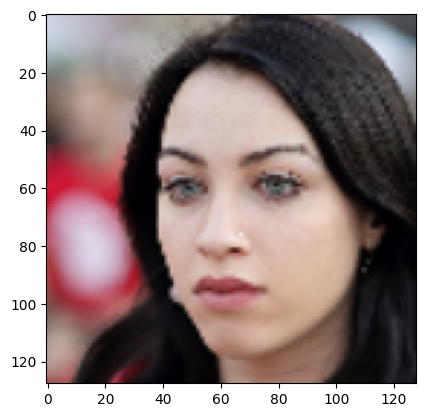

In [ ]:
# Choosing random image
rn = np.random.randint(0,50)
random_image_dir = images[rn]
# Open image on python
random_image = PIL.Image.open(random_image_dir)
# Show image
plt.imshow(random_image)

General function and classes

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# ROC drawing
def draw_roc(y_true, y_hat_one_hotted):
    one_hot_label = LabelBinarizer().fit_transform(y_true)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(8):
        fpr[i], tpr[i], _ = roc_curve(one_hot_label[:, i], y_hat_one_hotted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
    for i, color in zip(range(8), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for 8-class Classification')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# def count_parameters(model):
#     total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     layer_params = {name: p.numel() for name, p in model.named_parameters() if p.requires_grad}
#     return total_params, layer_params

# total, sep = count_parameters(alex)
# print(f'Total number of parameters is {total}')
# print(f'for each layer, there is :\n{sep}')

# Pytorch

## 1-2

Applying required transforms and augmentations

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

Loading data

In [ ]:
# Required Trnasforms on images
data_augmentation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda x: x/255)
    ]
)

# Setting the Train data
train_data = datasets.ImageFolder(
    os.path.join(data_dir,'TRAIN'),
    transform = data_augmentation
)

# Setting the Tune data
# With augmentation
tune_data = datasets.ImageFolder(
    os.path.join(data_dir,'TUNE'),
    transform = data_augmentation
)
# Without Augmentation
tune_data_no_aug = datasets.ImageFolder(
    os.path.join(data_dir, 'TUNE')
)

Split to trian-val

In [ ]:
# Length of sets
train_len = int(0.8*len(train_data))
val_len = len(train_data) - train_len

# Splitting
training_data, val_data = random_split(train_data, [train_len, val_len])

## 1-3

Implementing AlexNet

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import tqdm
from sklearn.metrics import confusion_matrix

In [ ]:
# Conv layer
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.max_pool(x)
        # x = self.dropout(x)
        return x

# Network
class AlexNet(nn.Module):

    def __init__(self,device):
        device = device
        super(AlexNet,self).__init__()
        self.convlayer = lambda a,b,ks: ConvLayer(a,b,ks).to(device)
        self.dense1 = nn.Linear(8192, 1024)
        self.dense1_2 = nn.Linear(1024,1024)
        self.dense1_3 = nn.Linear(1024,512)
        self.dense2 = nn.Linear(512, 8)
        self.faltten = nn.Flatten()
        self.device = device

    def forward(self,x):
        x = self.convlayer(3,16,9)(x)
        x = self.convlayer(16,32,7)(x)
        x = self.convlayer(32,64,5)(x)
        x = self.convlayer(64,128,3)(x)
        # x = self.convlayer(128,128,3)(x)
        x = self.faltten(x)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense1_2(x))
        x = F.relu(self.dense1_3(x))
        x = F.softmax(self.dense2(x))
        return x

# Train function
def train_model(
    data,
    model,
    epochs = 5,
    criterion = None,
    optimizer = None,
    device = None
    ):
    '''
    Function to train the model for the given data
    '''
    # Train loop
    loss_array = []
    acc_array =[]
    for j in range(epochs):

        td = iter(data) # Setting data as and iter object
        acc = 0
        l = 0

        # Train for an epoch
        pbar = tqdm.trange(len(data), desc=f'Epoch {j+1}')
        for i in pbar:

            # input and target data
            input, t = next(td)
            t = torch.eye(8)[t]
            # Apply input and target into device
            input, t = input.to(device), t.to(device)

            optimizer.zero_grad()
            y_hat = model(input)
            loss = criterion(y_hat,t)
            loss.backward()
            optimizer.step()

            # Train loss and accuracy
            b_acc = batch_acc(model, input, t)
            b_l = batch_loss(model,criterion,input,t)

            acc = (acc*i + b_acc)/(i+1)
            l = (l*i + b_l)/(i+1)

            pbar.set_description(f'Epoch {j+1} Acc: {acc:.4f} Loss: {l:.4f}')

        acc_array.append(acc)
        loss_array.append(l)
    return {'loss':loss_array, 'acc':acc_array}

# Calculating accuracy
def batch_acc(model, inputs, targets):
    # Set model to evaluation mode
    model.eval()

    # Initialize variables to keep track of total and correct predictions
    total_correct = 0
    total_samples = 0

    # Disable gradient calculation
    with torch.no_grad():
        # Perform forward pass
        outputs = model(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Update total number of samples
        total_samples += targets.size(0)

        # Update number of correct predictions
        total_correct += (predicted == targets).sum().item()

    # Calculate accuracy
    accuracy = total_correct / total_samples
    model.train()
    return accuracy

# loss
def batch_loss(model, criterion, inputs, targets):
    # Set model to evaluation mode
    model.eval()

    # Initialize variables to keep track of total loss and number of samples
    total_loss = 0.0
    total_samples = 0

    # Disable gradient calculation
    with torch.no_grad():

        # Perform forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        # Update total loss and number of samples
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    # Calculate average loss
    epoch_loss = total_loss / total_samples
    model.train()
    return epoch_loss

# Prediction function
def predict_input(model, dataloader, device, to_numpy=False):
    # Set model to evaluation mode
    model.eval()

    predictions = []
    targets = []

    # Iterate over batches in the DataLoader
    data = tqdm.tqdm(dataloader)
    for batch,target_batch in data:
        # Extract input data from the batch
        input_data = batch.to(device)
        target_batch = target_batch.to(device)

        # Move input data to the appropriate device if needed
        # For example, if your model is on GPU
        # input_data = input_data

        # Disable gradient computation
        with torch.no_grad():
            # Forward pass
            output = model(input_data)

        # Append predictions for this batch
        predictions.append(output)
        targets.append(target_batch)

    # Concatenate predictions for all batches along the batch dimension
    # Assuming output of model is a tensor
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets,dim=0)

    # Optionally, post-process predictions if needed
    if to_numpy:
        predictions = predictions.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()

    model.train()
    # Return the predictions
    return predictions,targets


In [ ]:
# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Defining the model
alex = AlexNet(device).to(device)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(alex.parameters(), lr=0.0001)

In [ ]:
# Loading data for train and test
train_loader = DataLoader(training_data,batch_size=128, shuffle=True)
val_loader = DataLoader(val_data)

In [ ]:
epochs = 20
data = train_loader
optimizer = optimizer
model = alex
criterion = criterion


hist_1 = train_model(data, model, epochs, criterion, optimizer,device)

Epoch 1:   0%|          | 0/50 [00:15<?, ?it/s]


RuntimeError: The size of tensor a (128) must match the size of tensor b (8) at non-singleton dimension 1

In [ ]:
output, true_targets = predict_input(model, train_loader, device, True)
output_1 = np.argmax(output,axis=1)

100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


In [ ]:
from sklearn.metrics import classification_report

cls_report = classification_report(true_targets, output_1)

print(cls_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       778
           1       0.13      1.00      0.23       815
           2       0.00      0.00      0.00       815
           3       0.00      0.00      0.00       794
           4       0.00      0.00      0.00       819
           5       0.00      0.00      0.00       785
           6       0.00      0.00      0.00       789
           7       0.00      0.00      0.00       805

    accuracy                           0.13      6400
   macro avg       0.02      0.12      0.03      6400
weighted avg       0.02      0.13      0.03      6400



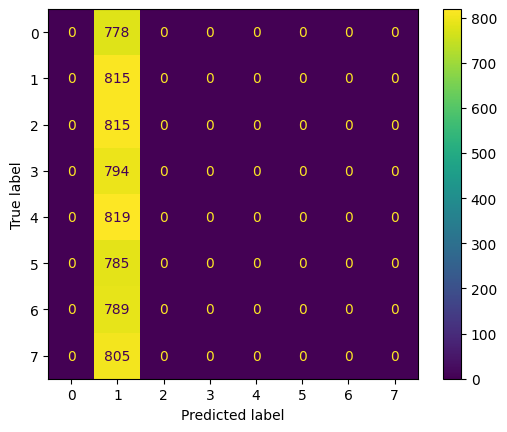

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(true_targets, output_1)


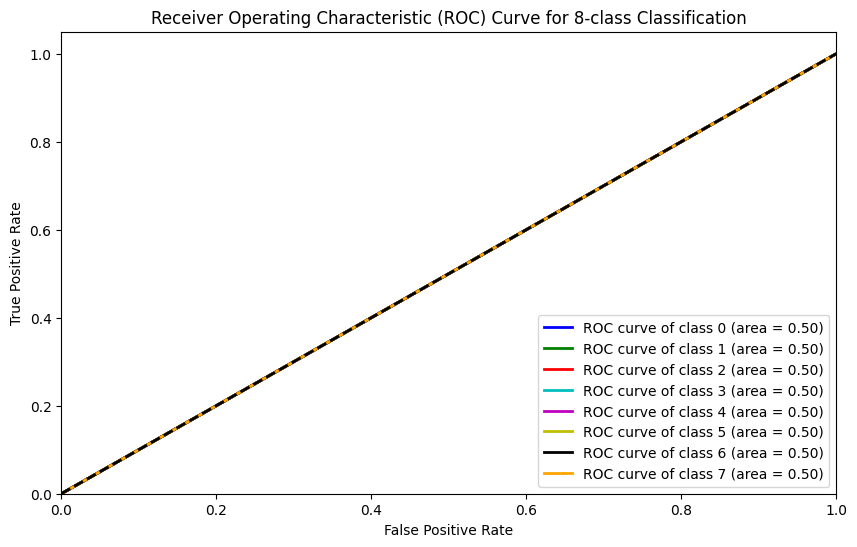

In [ ]:
draw_roc(true_targets, output)

## 2-1

In [ ]:
# Conv layer
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.max_pool(x)
        return x

# Network
class VGG(nn.Module):

    def __init__(self,device):
        device = device
        super(VGG,self).__init__()
        self.convlayer = lambda a,b,ks: ConvLayer(a,b,ks).to(device)
        self.dense1 = nn.Linear(4*4*128, 1024)
        self.dense1_2 = nn.Linear(1024,1024)
        self.dense2 = nn.Linear(1024, 8)
        self.faltten = nn.Flatten()
        self.device = device

    def forward(self,x):
        x = self.convlayer(3,16,3)(x)
        x = self.convlayer(16,32,3)(x)
        x = self.convlayer(32,64,3)(x)
        x = self.convlayer(64,128,3)(x)
        x = self.convlayer(128,128,3)(x)
        x = self.faltten(x)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense1_2(x))
        x = F.softmax(self.dense2(x),dim=1)
        return x

In [ ]:
# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Defining the model
vgg = VGG(device).to(device)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)

In [ ]:
# Loading data for train and test
train_loader = DataLoader(training_data,batch_size=128, shuffle=True)
val_loader = DataLoader(val_data)

In [ ]:
epochs = 10
data = train_loader
optimizer = optimizer
model = vgg
criterion = criterion


hist_1 = train_model(data, model, epochs, criterion, optimizer,device)

Epoch 10 Acc: 0.1453 Loss: 2.0723: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


# Tensor flow

## 1-2

Applying required transforms and augmentations

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

In [ ]:
# Required transformations
train_transform = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip=True
)

# Applying the transforms
# And creating an image generator for train images
train_generator = train_transform.flow_from_directory(
    '/content/Dataset/TRAIN',
    target_size = (128,128),
    color_mode = 'rgb',
    batch_size = 100,
    class_mode = 'categorical'
)

Found 8000 images belonging to 8 classes.


In [ ]:
train_generator.classes[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## 1-3

Implementing AlexNet

In [ ]:
# Convolution Layer
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='same'):
        super(ConvLayer, self).__init__()
        self.conv = Conv2D(filters, kernel_size, strides=strides, padding=padding)
        self.batch_norm = BatchNormalization()
        self.max_pool = MaxPooling2D(pool_size=(2, 2), strides=2)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        x = tf.nn.relu(x)
        x = self.max_pool(x)
        return x


# Defining AlexNet layers
dense = lambda u,ac: Dense(units = u, activation = ac,)
flat = Flatten()

input_layer = Input(shape=(128,128,3))
x = ConvLayer(16,9)(input_layer)
x = ConvLayer(32,7)(x)
x = ConvLayer(64,5)(x)
x = ConvLayer(128,3)(x)
x = ConvLayer(128,3)(x)
x = flat(x)
x = dense(1024,'relu')(x)
x = dense(1028,'relu')(x)
output = dense(8,'softmax')(x)

alex_tf = Model(inputs=input_layer, outputs=output)

In [ ]:
inp_layer = Input(shape = (128, 128, 3))

conv1 = Conv2D(filters = 16, kernel_size=(9, 9), strides = (1, 1), padding = 'same')(inp_layer)
bn1 = BatchNormalization()(conv1)
maxp1 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(bn1)

conv2 = Conv2D(filters = 32, kernel_size=(7, 7), strides = (1, 1), padding = 'same')(maxp1)
bn2 = BatchNormalization()(conv2)
maxp2 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(bn2)

conv3 = Conv2D(filters = 64, kernel_size=(5, 5), strides = (1, 1), padding = 'same')(maxp2)
bn3 = BatchNormalization()(conv3)
maxp3 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(bn3)

conv4 = Conv2D(filters = 128, kernel_size=(3, 3), strides = (1, 1), padding = 'same')(maxp3)
bn4 = BatchNormalization()(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(bn4)

conv5 = Conv2D(filters = 128, kernel_size=(3, 3), strides = (1, 1), padding = 'same')(maxp4)
bn5 = BatchNormalization()(conv5)
maxp5 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(bn5)

flat  = Flatten()(maxp5)
FC1   = Dense(units = 1024, activation = 'relu')(flat)
FC2   = Dense(units = 1024 , activation = 'relu')(FC1)
output = Dense(units = 8, activation = 'softmax')(FC2)

alex_tf = Model(inputs = inp_layer, outputs = output)

In [ ]:
opt = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
alex_tf.compile(optimizer=opt, loss = loss, metrics = 'acc')

In [ ]:
history = alex_tf.fit(
    train_generator,
    epochs = 30
)

Epoch 1/30
80/80 [==============================] - 49s 481ms/step - loss: 2.4395 - acc: 0.1505
Epoch 2/30
80/80 [==============================] - 40s 500ms/step - loss: 2.0435 - acc: 0.1791
Epoch 3/30
80/80 [==============================] - 40s 496ms/step - loss: 2.0046 - acc: 0.1960
Epoch 4/30
80/80 [==============================] - 40s 499ms/step - loss: 1.9498 - acc: 0.2200
Epoch 5/30
80/80 [==============================] - 42s 519ms/step - loss: 1.8822 - acc: 0.2525
Epoch 6/30
80/80 [==============================] - 40s 505ms/step - loss: 1.7753 - acc: 0.2966
Epoch 7/30
80/80 [==============================] - 40s 504ms/step - loss: 1.6703 - acc: 0.3426
Epoch 8/30
80/80 [==============================] - 42s 519ms/step - loss: 1.5937 - acc: 0.3761
Epoch 9/30
80/80 [==============================] - 48s 595ms/step - loss: 1.5418 - acc: 0.3994
Epoch 10/30
80/80 [==============================] - 40s 496ms/step - loss: 1.4685 - acc: 0.4381
Epoch 11/30
80/80 [====================

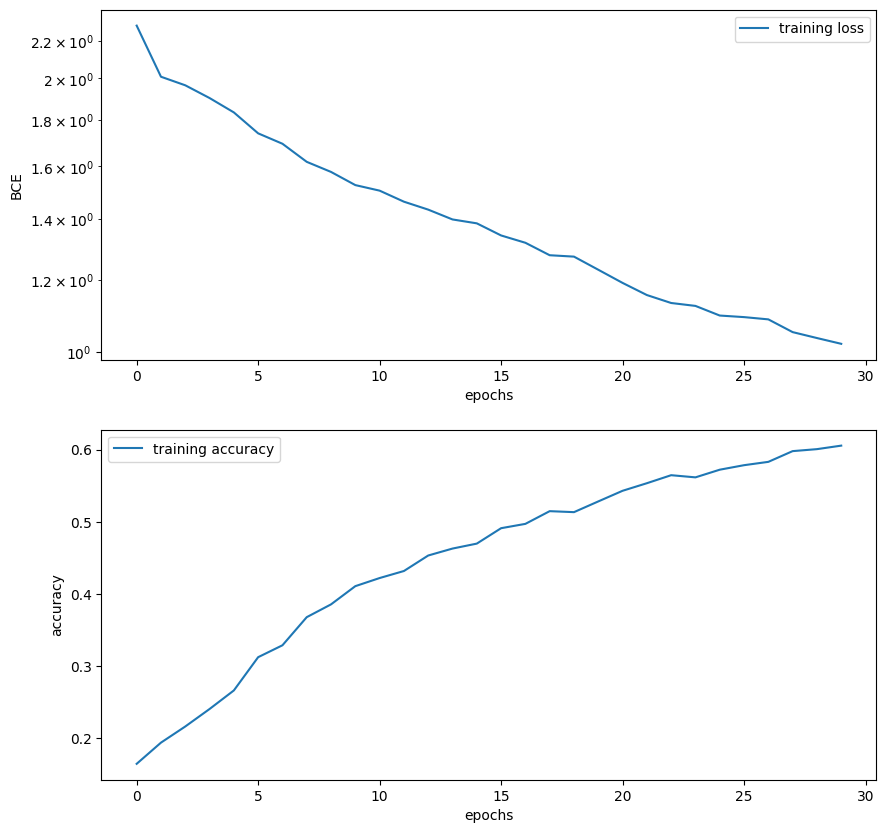

In [ ]:
train_loss = history.history['loss']
# val_loss = history.history['val_loss']
train_acc = history.history['acc']
# val_acc = history.history['val_acc']


plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
# plt.semilogy(val_loss)

plt.legend(['training loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
# plt.plot(val_acc)

plt.legend(['training accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat_trian = alex_tf.predict(train_generator)
y_hat_train = np.argmax(y_hat_trian,axis=1)

80/80 [==============================] - 37s 460ms/step


In [ ]:
import tqdm

In [ ]:
da = iter(train_generator)

t_labels = []
for _,la in tqdm.tqdm(da):
    t_labels.append(la)
    if len(t_labels)==len(da):
        break

 99%|█████████▉| 79/80 [00:36<00:00,  2.15it/s]


In [ ]:
tt = np.array(t_labels)
tt = tt.reshape(-1,8)
print(tt.shape)
print(y_hat_train.shape)

(8000, 8)
(8000,)


In [ ]:
print(np.sum(np.argmax(tt,axis=1) == y_hat_train))
print()

1014



In [ ]:
from sklearn.metrics import classification_report

cls_report = classification_report(np.argmax(tt,axis=1), y_hat_train)

print(cls_report)

              precision    recall  f1-score   support

           0       0.13      0.14      0.14       991
           1       0.12      0.12      0.12       991
           2       0.13      0.09      0.10       988
           3       0.14      0.15      0.14      1019
           4       0.13      0.12      0.13      1023
           5       0.12      0.13      0.12       992
           6       0.12      0.11      0.12       979
           7       0.13      0.15      0.14      1017

    accuracy                           0.13      8000
   macro avg       0.13      0.13      0.13      8000
weighted avg       0.13      0.13      0.13      8000



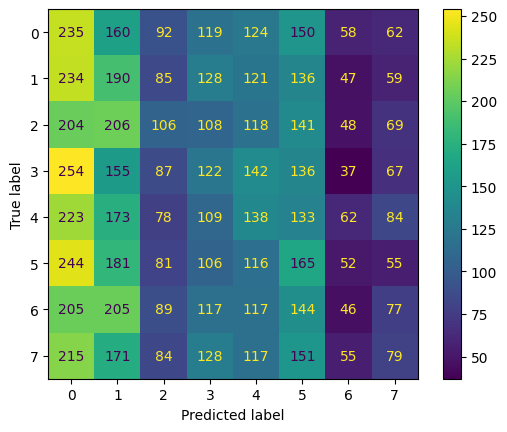

In [ ]:
zfrom sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(train_generator.classes, y_hat_train)


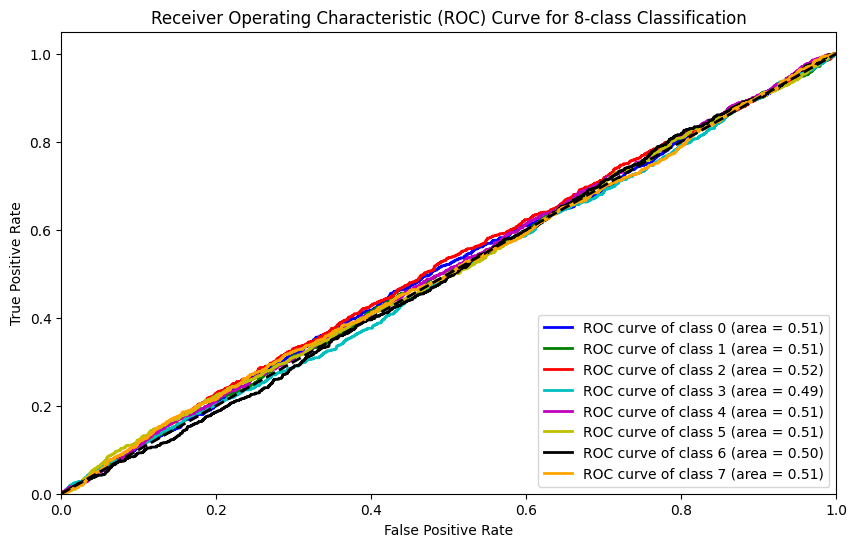

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

one_hot_label = LabelBinarizer().fit_transform(train_generator.classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(one_hot_label[:, i], y_hat_trian[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 8-class Classification')
plt.legend(loc="lower right")
plt.show()

# other

In [ ]:
# Implement VGG-16
# Set name for all layers
# fix count_parameters function